In [2]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sklearn.metrics as skm

def get_mixture_labels(cn_data, obs_name="bhc_cluster_id", exp_name="origin_id_int"):
    sub_cn_data = cn_data[["cell_id", obs_name, exp_name]].drop_duplicates()
    return sub_cn_data

In [3]:
cn_data_fp = "/Users/massoudmaher/data/sc1935to37_spike_in_chrX.csv"
cn_data = pd.read_csv(cn_data_fp).iloc[:,1:]

In [3]:
# bhc params
n_states = 8
alpha = 3
prob_cn_change = 0.9

# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

In [4]:
start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy")
)
print(f"{time.time()-start}s for BHC on {total_ncells} cells")

14.698323965072632s for BHC on 100 cells


/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


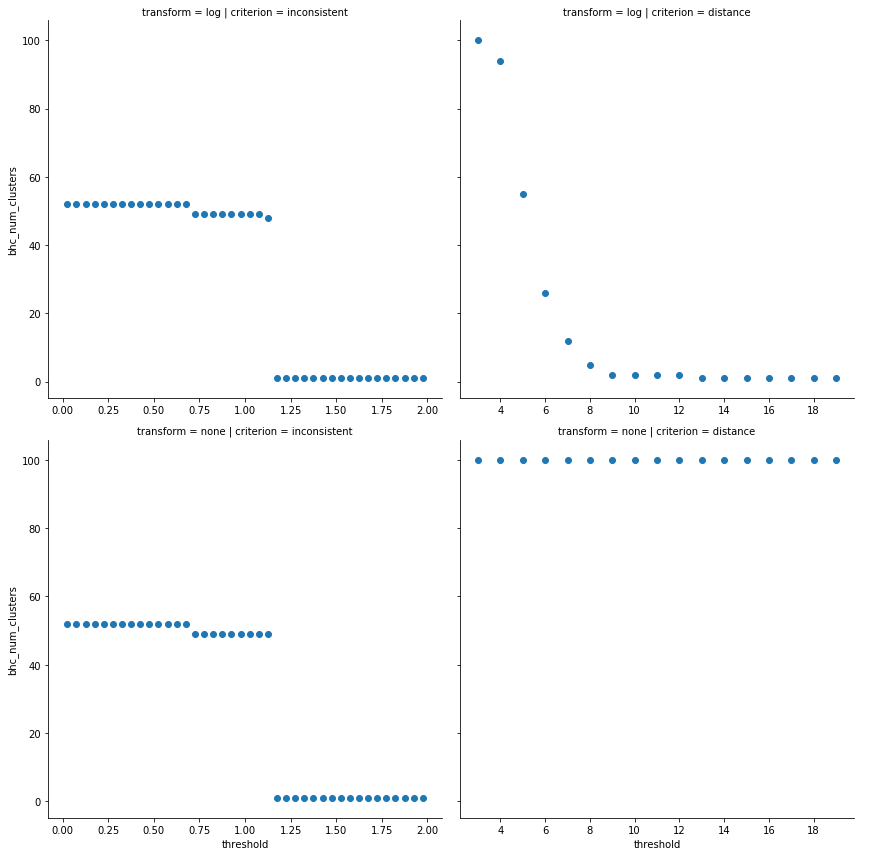

In [5]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(bhc_plot_data[:,2]) # Log because the highest link is way higher

def apply_fn(row):
    if row["transform"] == "log":
        df = lbhc_plot_data
    else:
        df = bhc_plot_data
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["bhc_fcluster"] = params.apply(apply_fn, axis=1)
params["bhc_num_clusters"] = params["bhc_fcluster"].apply(lambda x: len(set(x)))

g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "bhc_num_clusters")

homogeneity: 0.5148151211620298, completeness: 0.44358881820239643, v-measure: 0.47655528490509197


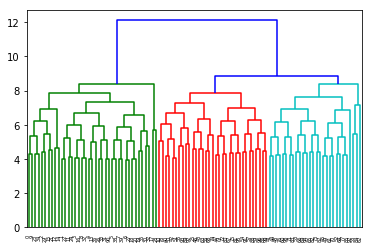

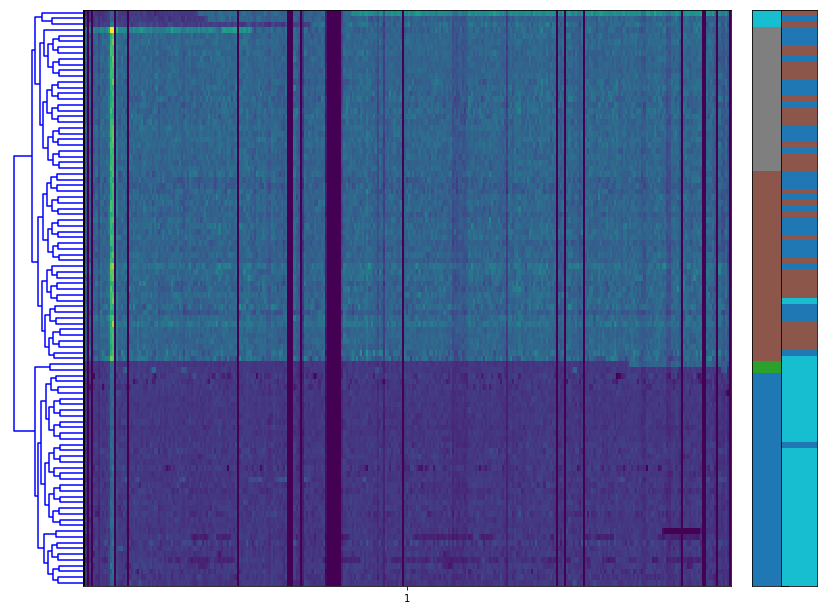

In [6]:
bhc_clusters = sch.fcluster(lbhc_plot_data, 8, criterion="distance")
assert len(set(bhc_clusters)) > 1
cn_data = cncluster.prune_cluster(bhc_clusters, bhc_cell_ids, cn_data)
cn_data["origin_id_int"] = cn_data["origin_id"].factorize()[0]

fig = plt.figure(figsize=(10, 8))
bimatrix_data, ps = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int", raw=True, flip=True, cell_id_order = bhc_cell_ids)
clabels = get_mixture_labels(cn_data)
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["bhc_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

In [22]:
bhc_linkage.dtypes

i                 object
j                 object
r_merge          float64
naive_dist        object
log_like          object
i_count           object
j_count           object
merge_count       object
dist             float64
cmerge_count    category
dtype: object

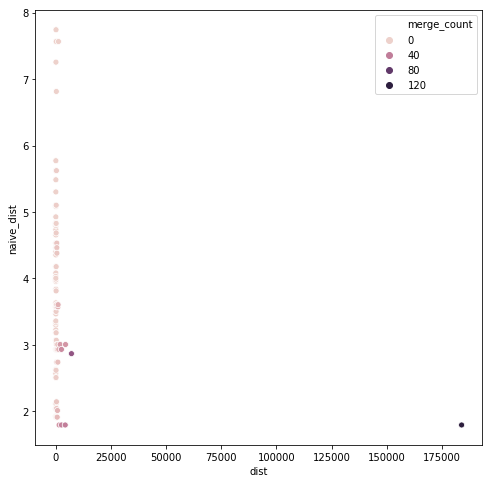

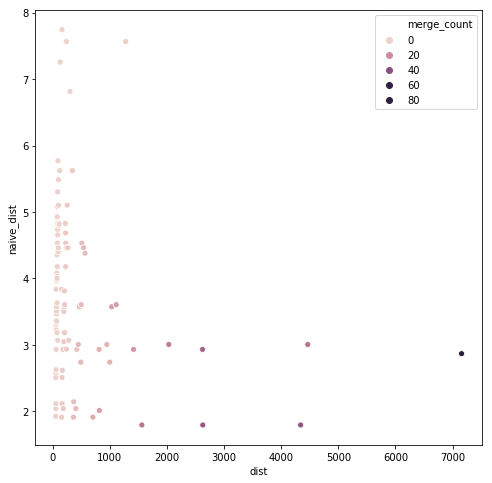

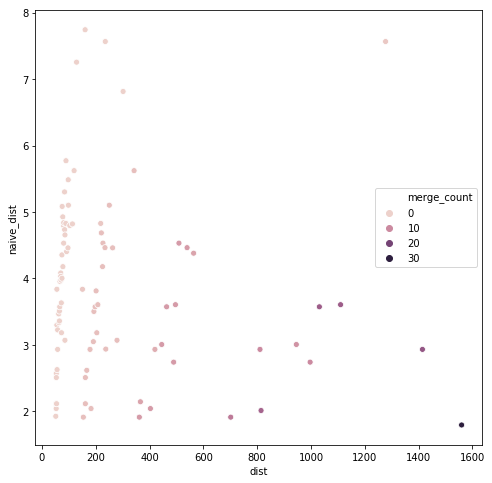

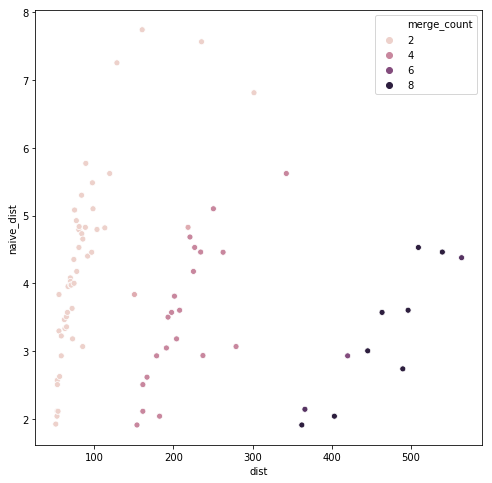

In [30]:
bhc_linkage["merge_count"] = bhc_linkage["merge_count"].astype("int")
plt.figure(figsize=(8,8))
sns.scatterplot(data=bhc_linkage[bhc_linkage["dist"]<750000000], x="dist", y="naive_dist", hue="merge_count")
plt.figure(figsize=(8,8))
sns.scatterplot(data=bhc_linkage[bhc_linkage["dist"]<75000], x="dist", y="naive_dist", hue="merge_count")
plt.figure(figsize=(8,8))
sns.scatterplot(data=bhc_linkage[bhc_linkage["dist"]<2000], x="dist", y="naive_dist", hue="merge_count")
plt.figure(figsize=(8,8))
sns.scatterplot(data=bhc_linkage[bhc_linkage["dist"]<600], x="dist", y="naive_dist", hue="merge_count")

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


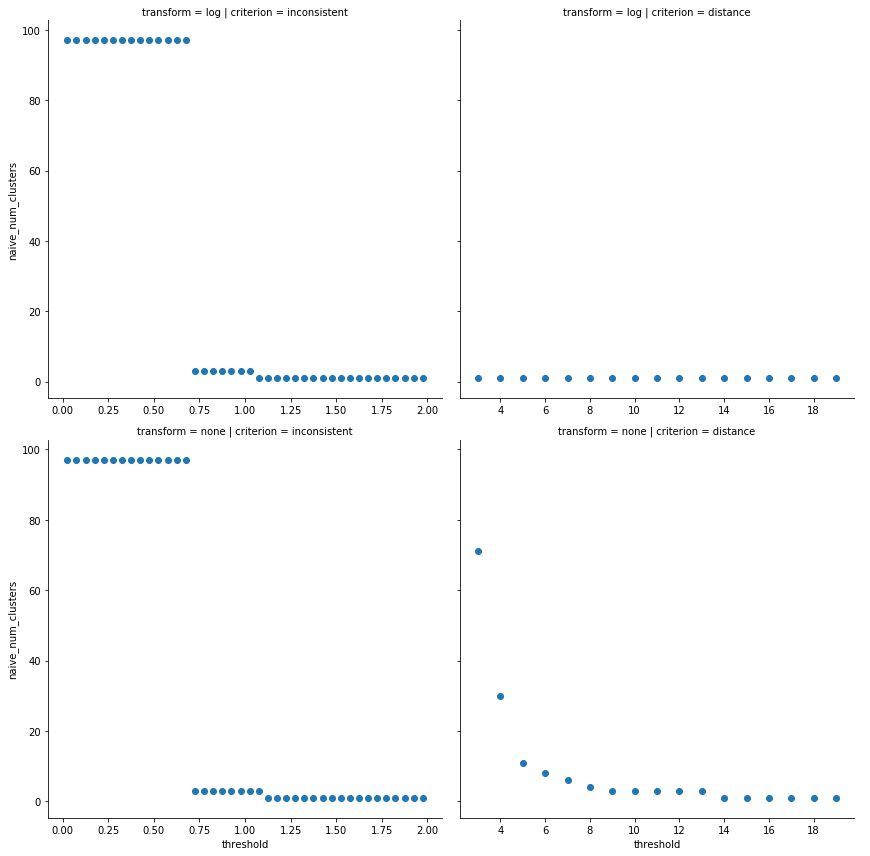

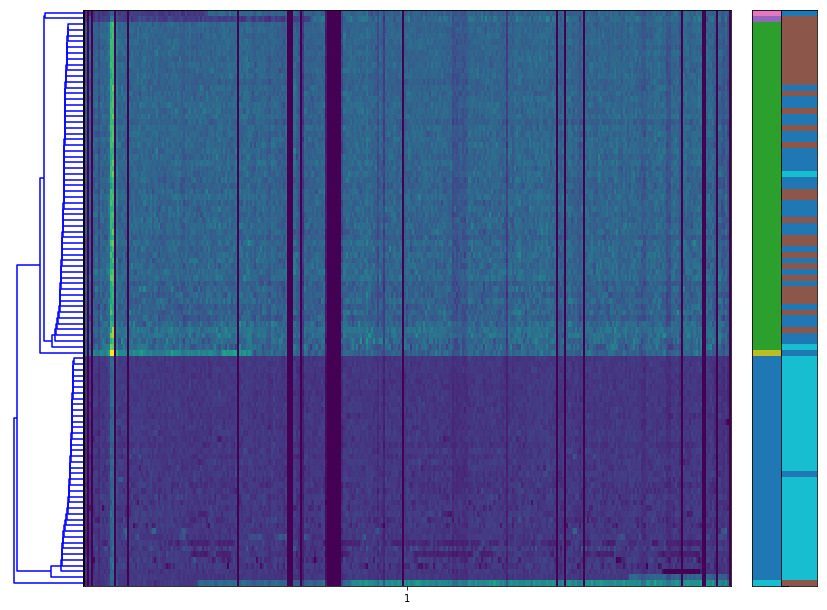

In [48]:
df_meas = pd.DataFrame(data=measurement, index=bhc_cell_ids)
naive_linkage = sch.linkage(np.nan_to_num(measurement))

# Select clustering params
lnaive_linkage = naive_linkage.copy()
lnaive_linkage[:,2] = np.log(lnaive_linkage[:,2]) # Log because the highest link is way higher

def apply_fn(row):
    if row["transform"] == "log":
        df = lnaive_linkage
    else:
        df = naive_linkage
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["naive_fcluster"] = params.apply(apply_fn, axis=1)
params["naive_num_clusters"] = params["naive_fcluster"].apply(lambda x: len(set(x)))

g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "naive_num_clusters")

naive_clusters = sch.fcluster(naive_linkage, 7, criterion="distance")
assert len(set(naive_clusters)) > 1
cn_data = cncluster.prune_cluster(naive_clusters, bhc_cell_ids, cn_data, cluster_field_name="naive_cluster_id")

fig = plt.figure(figsize=(10, 8))
naive_matrix_data, ps = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="naive_cluster_id",
    linkage=naive_linkage, origin_field_name="origin_id_int", raw=True, flip=True, cell_id_order = bhc_cell_ids)

In [59]:
bhc_linkage[bhc_linkage["r_merge"] <= -2]
#sns.boxplot(bhc_linkage[bhc_linkage["r_merge"] >= -2]["r_merge"])

,i,j,r_merge,naive_dist,log_like,i_count,j_count,merge_count,dist,cmerge_count
0,6,27,-51.613338,1.92366,512.749,1,1,2,51.613338,2
1,1,22,-53.134899,2.03998,454.546,1,1,2,53.134899,2
2,18,20,-53.442716,2.11635,465.691,1,1,2,53.442716,2
3,7,39,-53.480428,2.5689,371.205,1,1,2,53.480428,2
4,26,33,-53.647415,2.50643,429.746,1,1,2,53.647415,2
5,5,38,-54.468717,2.11262,458.001,1,1,2,54.468717,2
6,31,90,-55.621143,3.29754,284.23,1,1,2,55.621143,2
7,4,13,-55.687444,3.83591,252.305,1,1,2,55.687444,2
8,3,16,-56.496314,2.62594,379.423,1,1,2,56.496314,2
9,42,51,-58.553514,2.93067,196.204,1,1,2,58.553514,2


/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-10000, 0)

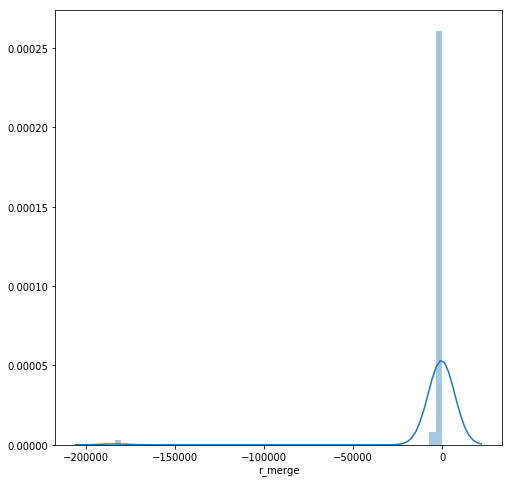

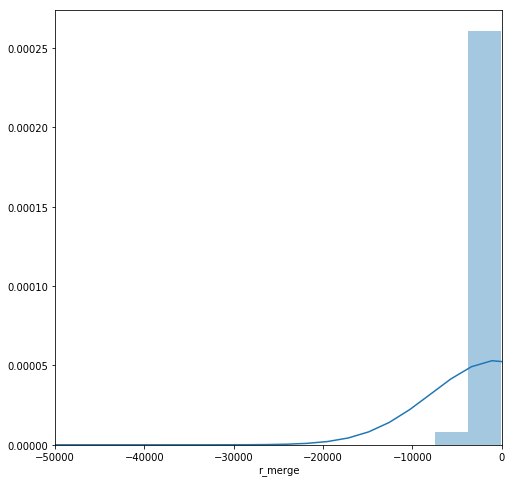

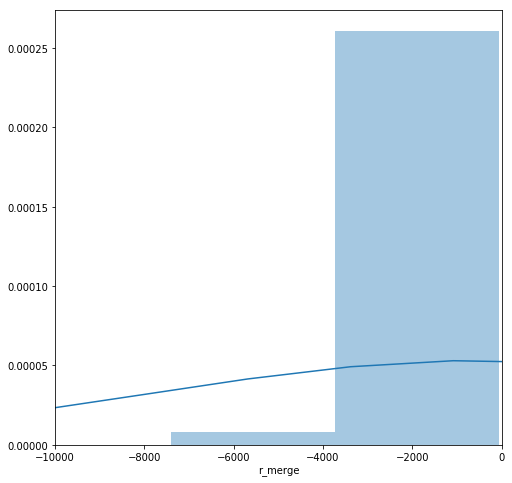

In [65]:
fig = plt.figure(figsize=(8,8))
sns.distplot(bhc_linkage["r_merge"])

fig = plt.figure(figsize=(8,8))
sns.distplot(bhc_linkage["r_merge"])
plt.xlim(-50000,0)

fig = plt.figure(figsize=(8,8))
sns.distplot(bhc_linkage["r_merge"])
plt.xlim(-10000,0)

,chr,chromosome_start,chromosome_end
0,NaN,0,249250621
1,NaN,249250621,492449994
2,NaN,492449994,690472424
3,NaN,690472424,881626700
4,NaN,881626700,1062541960
5,NaN,1062541960,1233657027
6,NaN,1233657027,1392795690
7,NaN,1392795690,1539159712
8,NaN,1539159712,1680373143
9,NaN,1680373143,1815907890


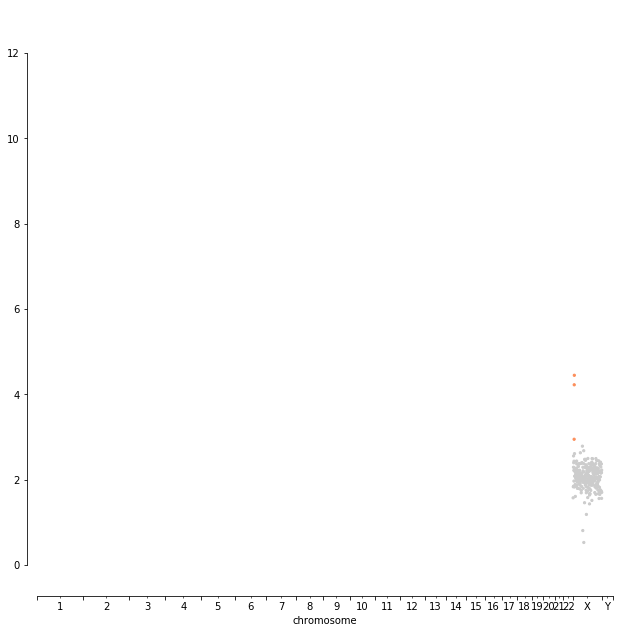

In [22]:
cn_data.columns

Index(['chr', 'start', 'end', 'reads', 'gc', 'copy', 'state', 'cell_id',
       'sample_id', 'library_id', 'origin_id', 'origin_id_int'],
      dtype='object')